# <center> LSTM model for Sentiment polarity prediction

In this notebook we will perform,

* Polarity of a review as either poisitive or negative.

* We use data from Amazon fine food reviews, downloaded from Kaggle.

* We will construct 2 different LSTM architectures and compare performance of those models.

In [2]:
import numpy as np
import sqlite3
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from keras.initializers import glorot_normal
from keras.initializers import he_normal
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense,BatchNormalization
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from datetime import datetime as dt

# To ignore the warnings.
import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


* Loading Data:

In [0]:
con=sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database.sqlite')

In [0]:
data=pd.read_sql_query('''Select * from Reviews''',con)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## <center> Data preprocessing

Converting scores from [1-5] as positive and negative.

In [0]:
#Converting scores to Positive or negative

def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'
    
tmp=data['Score']
new=tmp.map(partition)
data['Score']=new

In [0]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
dedup_data=data.drop_duplicates(subset={"UserId",'ProfileName','Time','Text'},keep='first', inplace= False)
dedup_data=dedup_data[dedup_data.HelpfulnessNumerator <= dedup_data.HelpfulnessDenominator]


In [0]:
import re

def cleanHtml(s):
    clean=re.compile('<.*?>')
    cleared= re.sub(clean,' ',s)
    return cleared

def cleanPunc(s):
    cleared=re.sub('[?|!|\'|"|(|)|.|#|]',r' ',s)
    return cleared


Below function removes HTML , punctuations, numbers etc and convert each words to lower.

* Here we didn't removed stop words as it may provide better gramatical meanings with text data.

In [0]:
#Program to clean the words

import time
i=0 #Review counter
str=''
filtered_text=[]
start=time.time()
print('Operation started at : {} '.format(start))
for sentence in tqdm(dedup_data['Text'].values):
    filtered_sentence=[]
    clean=cleanHtml(sentence)
    clean=cleanPunc(clean)
    for words in clean.split():
        #print(type(words))
        if(words.isalpha()):
            word=words.lower()
            filtered_sentence.append(word)                
        else:
            continue
            
    str1=' '.join(filtered_sentence)    
    filtered_text.append(str1)
    i+=1

dedup_data['New']=filtered_text
end=time.time()-start
print('Time taken = {} '.format(end))


  1%|          | 2172/393931 [00:00<00:18, 21714.43it/s]

Operation started at : 1549995387.6400065 


100%|██████████| 393931/393931 [00:19<00:00, 20174.92it/s]


Time taken = 19.621785163879395 


In [0]:
dedup_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide ...


In [0]:
dedup_data.New[5]

'i got a wild hair for taffy and ordered this five pound bag the taffy was all very enjoyable with many root etc my only complaint is there was a bit too much pieces just not my particular favorites between my and my this lasted only two weeks i would recommend this brand of taffy it was a delightful treat'

In [0]:
conn=sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database_lstm.sqlite')
conn.text_factory=str
dedup_data.to_sql('Reviews',conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

* All preprocessing steps are completed and it was stored in a new DB file for later usage.

In [0]:
a=sqlite3.connect('/content/drive/My Drive/Colab Notebooks/database_lstm.sqlite')
data1=pd.read_sql_query('''Select * from Reviews''',a)
data1.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,New
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,i have bought several of the vitality canned d...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled as jumbo salted peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this is a confection that has been around a fe...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,if you are looking for the secret ingredient i...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy at a great price there was a wide ...


## <center> Time based sorting of data

* Since we have date & time feature on data, we can use time based sorting.

In [0]:
sorted_data=data1.sort_values('Time',axis=0,ascending=True)

## <center> Splitting of data into Test and Train

* We split the entire data to train & test split.

In [0]:
train_length=round(0.7*len(data1))
print(train_length)
test_length=round(0.3*len(data1))
print(test_length)
print((train_length+test_length)==len(data1))

275752
118179
True


In [0]:
train=sorted_data.head(train_length)
test=sorted_data.tail(test_length)

## <center>  Preparing text data 

* The text data needs to be converted into format, appropriate for sending it through LSTM network. We will do all such formattings to the input data in below cells.

In [0]:
word_corpus=[]
for sentence in tqdm(train['New'].values):
    for words in sentence.split():
      word_corpus.append(words)

100%|██████████| 275752/275752 [00:05<00:00, 47306.80it/s]


In [0]:
len(word_corpus)

20810046

* I used counter class from collection package to calculate the frequency of occurence of each words in the corpus of reviews in train data.

In [0]:
from collections import Counter
word_freq=Counter(word_corpus).most_common()

In [0]:
len(word_freq)

83497

* Total number of unique words in vocabulary is 83497.

In [0]:
word_freq

[('the', 900614),
 ('i', 797219),
 ('and', 610389),
 ('a', 578077),
 ('it', 506934),
 ('to', 485641),
 ('of', 382666),
 ('is', 352472),
 ('this', 322221),
 ('in', 268180),
 ('for', 263989),
 ('that', 208734),
 ('my', 208705),
 ('you', 182291),
 ('but', 172441),
 ('with', 171459),
 ('have', 162864),
 ('not', 156935),
 ('was', 150593),
 ('are', 148239),
 ('they', 145516),
 ('s', 145113),
 ('t', 141691),
 ('as', 135062),
 ('on', 129683),
 ('like', 116576),
 ('so', 113539),
 ('these', 104729),
 ('them', 92151),
 ('be', 90668),
 ('good', 88064),
 ('at', 87390),
 ('or', 87296),
 ('can', 84823),
 ('just', 81696),
 ('if', 81411),
 ('very', 80495),
 ('one', 79418),
 ('great', 76266),
 ('taste', 75783),
 ('from', 71400),
 ('all', 70105),
 ('we', 69477),
 ('product', 66872),
 ('when', 64773),
 ('more', 62494),
 ('has', 61616),
 ('flavor', 61300),
 ('tea', 60760),
 ('had', 60112),
 ('coffee', 60088),
 ('will', 58510),
 ('love', 57200),
 ('would', 57183),
 ('than', 55995),
 ('me', 53130),
 ('out', 

In [0]:
# I considered only top 20000 words due to limitation of cumpute resource.
top_words =20000 

#Dimension of words out of embedding layer
embedding_vecor_length = 50

* Creating a vocabulary of top 20k words.

In [0]:
sorted_words_vocab=[]
top_words=20000
for i in range(0,top_words):
  sorted_words_vocab.append(word_freq[i][0])

* Testing the above ones with a sample data.

In [0]:
word_as_index=[]
for words in ['the','tea','is','great','and','i','love','it']:
  val=sorted_words_vocab.index(words)
  word_as_index.append(val)
word_as_index

[0, 48, 7, 38, 2, 1, 52, 4]

* Converting reviews in train data into corresponding word indices.

In [0]:
indexed_input_train=[]
for sentences in tqdm(train['New'].values):
  word_as_index=[]
  for words in sentences.split():
    if words in sorted_words_vocab:
      val=sorted_words_vocab.index(words)
      word_as_index.append(val)
    else:
      continue
  indexed_input_train.append(word_as_index)   

100%|██████████| 275752/275752 [13:31<00:00, 339.68it/s]


In [0]:
indexed_input_train[33]

[34,
 7577,
 12,
 154,
 479,
 7,
 0,
 5093,
 965,
 7748,
 15,
 41,
 0,
 8953,
 2,
 8351,
 1435,
 17,
 5,
 29,
 1948,
 9852,
 18652,
 2,
 10087,
 8350,
 19,
 4085,
 9,
 8,
 1638,
 2,
 5215,
 7005,
 7,
 4882,
 1708,
 1,
 427,
 22,
 747,
 6108,
 38,
 274,
 1638,
 51,
 183,
 13,
 9]

* Similarly we convert reviews in test to indices of corresponding words.

In [0]:
indexed_input_test=[]
for sentences in tqdm(test['New'].values):
  word_as_index=[]
  for words in sentences.split():
    if words in sorted_words_vocab:
      val=sorted_words_vocab.index(words)
      word_as_index.append(val)
    else:
      continue
  indexed_input_test.append(word_as_index)  

100%|██████████| 118179/118179 [06:14<00:00, 315.70it/s]


In [0]:
indexed_input_test[33]

[38,
 333,
 10,
 0,
 93,
 341,
 340,
 3874,
 54,
 4531,
 8,
 46,
 1651,
 55,
 139,
 2183,
 5,
 3110,
 23,
 101,
 23,
 1891,
 55,
 1094,
 958,
 0,
 93,
 10,
 3,
 138,
 6,
 153,
 99,
 11,
 21,
 34,
 23,
 30,
 221,
 10,
 45,
 5,
 10795]

In [0]:
#with open(r'/content/drive/My Drive/Colab Notebooks/indexed_inputs_lstm_amazon.pickle','wb') as f:
  pickle.dump([indexed_input_train,indexed_input_test],f)

In [0]:
with open(r'/content/drive/My Drive/Colab Notebooks/indexed_inputs_lstm_amazon.pickle','rb') as f:
  input_data_train,input_data_test=pickle.load(f)

In [0]:
input_data_train[33]

[34,
 7577,
 12,
 154,
 479,
 7,
 0,
 5093,
 965,
 7748,
 15,
 41,
 0,
 8953,
 2,
 8351,
 1435,
 17,
 5,
 29,
 1948,
 9852,
 18652,
 2,
 10087,
 8350,
 19,
 4085,
 9,
 8,
 1638,
 2,
 5215,
 7005,
 7,
 4882,
 1708,
 1,
 427,
 22,
 747,
 6108,
 38,
 274,
 1638,
 51,
 183,
 13,
 9]

In [0]:
print(type(input_data_train[1]))
print(len(input_data_train[1]))

<class 'list'>
70


* Performing padding to make sure the data can be passed in batch to the LSTM layer.

In [0]:
# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(input_data_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(input_data_test, maxlen=max_review_length)

* Converting output labels as 0 & 1, instead of Negative and Positive.

In [0]:
def polarity(s):
  if s == 'positive':
    return 1
  elif s=='negative':
    return 0

y_train=list(map(polarity,train['Score'].values))
y_test= list(map(polarity,test['Score'].values))

print(y_train[2])
print(y_test[10])

1
0


## <center> Architecture 1

The first architecture is,

<b> Input -> Embedding -> LSTM1(100) -> Output </b>

In [0]:
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 50)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 1,060,501
Trainable params: 1,060,501
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
from datetime import datetime as dt

In [0]:
start=dt.now()
model_trained=model.fit(X_train[:100000], y_train[:100000], nb_epoch=10, batch_size=128,validation_data=(X_test[50000:65000], y_test[50000:65000]))
print(f'Time taken to train is : {dt.now()-start}')
# Final evaluation of the model
scores = model.evaluate(X_test[:50000], y_test[:50000], verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Instructions for updating:
Use tf.cast instead.
Train on 100000 samples, validate on 15000 samples
Epoch 1/10
100000/100000 [==============================] - 859s 9ms/step - loss: 0.2454 - acc: 0.9077 - val_loss: 0.2452 - val_acc: 0.8977
Epoch 2/10
100000/100000 [==============================] - 844s 8ms/step - loss: 0.1750 - acc: 0.9316 - val_loss: 0.2601 - val_acc: 0.8824
Epoch 3/10
100000/100000 [==============================] - 834s 8ms/step - loss: 0.1508 - acc: 0.9421 - val_loss: 0.2468 - val_acc: 0.9031
Epoch 4/10
100000/100000 [==============================] - 1438s 14ms/step - loss: 0.1298 - acc: 0.9502 - val_loss: 0.2570 - val_acc: 0.8987
Epoch 5/10
100000/100000 [==============================] - 1798s 18ms/step - loss: 0.1121 - acc: 0.9579 - val_loss: 0.2812 - val_acc: 0.8998
Epoch 6/10
100000/100000 [==============================] - 1813s 18ms/step - loss: 0.0965 - acc: 0.9646 - val_loss: 0.3002 - val_acc: 0.8979
Epoch 7/10
100000/100000 [=============================

#### Function to plot Epoch vs Loss

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def plotter(x, v, t):
    '''
    To plot Train and Validation loss VS Epochs
    '''
    plt.figure(figsize=(9,5))
    plt.plot(x, v, 'b', label="Validation Loss")
    plt.plot(x, t, 'r', label="Train Loss")
    plt.xlabel('Epochs',fontsize=13)
    plt.ylabel('Train & Valdation loss',fontsize=13)
    plt.title('Epoch vs Train & Validation loss ',fontsize=15)
    plt.legend()
    plt.show()

#### Epoch vs Loss plot

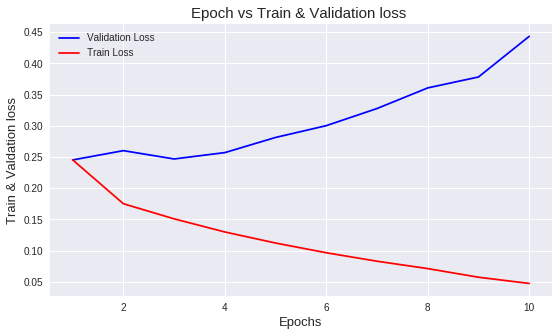

In [0]:
x=range(1,11)
validation_loss=model_trained.history['val_loss']
train_loss=model_trained.history['loss']

plotter(x,validation_loss,train_loss)

From above plot, it is clear that after 3 epochs, the train error started decreasing and test error started increasing. So model started overfitting after 3 epochs.

In [0]:
#with open(r'/content/drive/My Drive/Colab Notebooks/lstm_model1_amazon.pickle','wb') as f:
  pickle.dump(model,f)

#### Function to find performance of a model & to plot confusion matrices of train & test.

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from matplotlib import gridspec as gs
def CM(x,y,x1,y1):
    '''
    Function to plot confusion matrix and measure performance of a model
    '''
    CM_Matrix=confusion_matrix(x,y)
    CM_Matrix_train=confusion_matrix(x1,y1)
    print('\n******************************************************************************* \n')
    print(f' Accuracy of train is {accuracy_score(x1,y1)}\n')
    print(f' Accuracy of test is {accuracy_score(x,y)}')
    print('\n******************************************************************************* \n')
    
    #print(f" TNR value is {tn/(tn+fn)}")
    #print(f" FNR value is {fn/(tn+fn)}")
    #print(f" FPR value is {fp/(tp+fp)}")
    #print(f" TPR value is {tp/(tp+fp)}")
    
    
    print('Classification report of train is \n')
    print(classification_report(x1,y1,labels=[0,1]))
    print('\n******************************************************************************* \n')
    print('Classification report of test is \n')
    print(classification_report(x,y,labels=[0,1]))
    
    print('\n******************************************************************************* \n')
    print('Heat Map of the Confusion matrix is')
    g=gs.GridSpec(1,2)
    a=plt.figure(figsize=(15,5))
    plt.subplot(g[0,0])
    tmp=pd.DataFrame(CM_Matrix)
    tn,fp,fn,tp=CM_Matrix.ravel()
    ann=np.array([['True Negative = '+str(tn),'False Positive = '+str(fp)],['False Negative = '+str(fn),'True Positive = '+str(tp)]])
    sns.heatmap(tmp,annot=ann,fmt='',cmap="YlGnBu")
    plt.title('Confusion Matrix of test')
    
    plt.subplot(g[0,1])
    tmp=pd.DataFrame(CM_Matrix_train)
    tn,fp,fn,tp=CM_Matrix_train.ravel()
    ann=np.array([['True Negative = '+str(tn),'False Positive = '+str(fp)],['False Negative = '+str(fn),'True Positive = '+str(tp)]])
    sns.heatmap(tmp,annot=ann,fmt='',cmap="Greens")
    plt.title('Confusion Matrix of train')
    
    print('\n******************************************************************************* \n')
    
    

In [0]:
test_pred=model.predict_classes(X_test[:50000])
train_pred=model.predict_classes(X_train[:100000])

In [0]:
#with open(r'/content/drive/My Drive/Colab Notebooks/lstm1_amazon_predicted.pickle','wb') as f:
  pickle.dump([train_pred,test_pred],f)

In [0]:
with open(r'/content/drive/My Drive/Colab Notebooks/lstm1_amazon_predicted.pickle','rb') as f:
  train_pred,test_pred=pickle.load(f)


******************************************************************************* 

 Accuracy of train is 0.99018

 Accuracy of test is 0.89034

******************************************************************************* 

Classification report of train is 

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     11336
           1       0.99      0.99      0.99     88664

   micro avg       0.99      0.99      0.99    100000
   macro avg       0.98      0.97      0.98    100000
weighted avg       0.99      0.99      0.99    100000


******************************************************************************* 

Classification report of test is 

              precision    recall  f1-score   support

           0       0.68      0.64      0.66      8203
           1       0.93      0.94      0.93     41797

   micro avg       0.89      0.89      0.89     50000
   macro avg       0.80      0.79      0.80     50000
weighted avg       0.

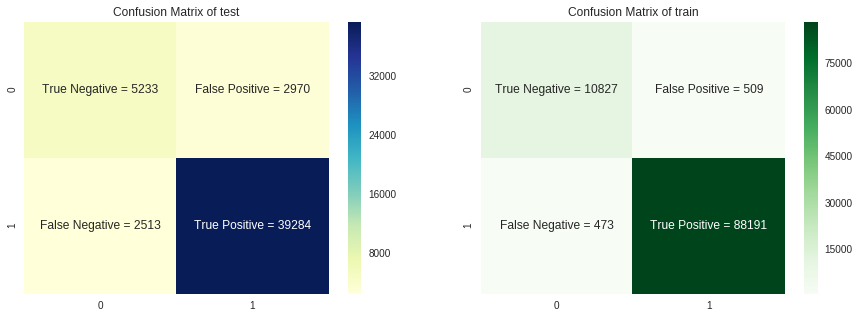

In [0]:
CM(y_test[:50000],test_pred,y_train[:100000],train_pred)

<b> Since after 3 epochs, the models started overfitting, let us decrease the number of epochs to 3 and implement the optimal model</b>

In [0]:
start=dt.now()
model_trained1=model.fit(X_train[:100000], y_train[:100000], nb_epoch=3, batch_size=128,validation_data=(X_test[50000:65000], y_test[50000:65000]))
print(f'Time taken to train is : {dt.now()-start}')
# Final evaluation of the model
scores = model.evaluate(X_test[:50000], y_test[:50000], verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 100000 samples, validate on 15000 samples
Epoch 1/3
100000/100000 [==============================] - 1784s 18ms/step - loss: 0.0418 - acc: 0.9860 - val_loss: 0.4523 - val_acc: 0.8947
Epoch 2/3
100000/100000 [==============================] - 1801s 18ms/step - loss: 0.0351 - acc: 0.9883 - val_loss: 0.4888 - val_acc: 0.8897
Epoch 3/3
100000/100000 [==============================] - 1768s 18ms/step - loss: 0.0287 - acc: 0.9911 - val_loss: 0.5228 - val_acc: 0.8854
Time taken to train is : 1:29:13.409425
Accuracy: 88.31%


In [0]:
test_pred=model.predict_classes(X_test[:50000])
train_pred=model.predict_classes(X_train[:100000])

#### Performance of Architecture 1:


******************************************************************************* 

 Accuracy of train is 0.99329

 Accuracy of test is 0.88314

******************************************************************************* 

Classification report of train is 

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11336
           1       1.00      0.99      1.00     88664

   micro avg       0.99      0.99      0.99    100000
   macro avg       0.98      0.99      0.98    100000
weighted avg       0.99      0.99      0.99    100000


******************************************************************************* 

Classification report of test is 

              precision    recall  f1-score   support

           0       0.65      0.64      0.64      8203
           1       0.93      0.93      0.93     41797

   micro avg       0.88      0.88      0.88     50000
   macro avg       0.79      0.78      0.79     50000
weighted avg       0.

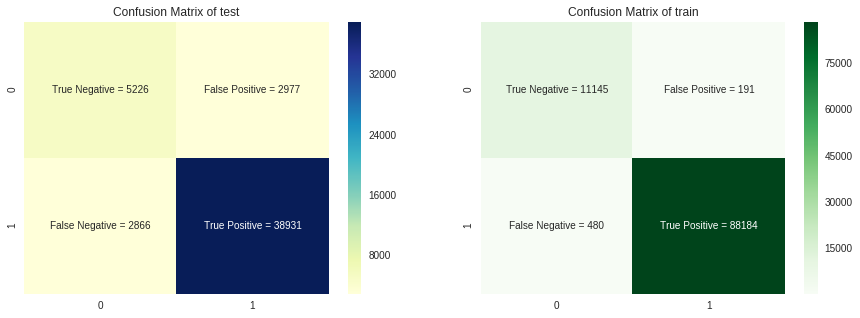

In [0]:
CM(y_test[:50000],test_pred,y_train[:100000],train_pred)

## <center> Architecture 2

The architecture is,

<b> Input -> Embedding -> LSTM1(64) -> LSTM(128) -> Dense(30) -> Output </b>

In [0]:
from keras.layers import Dropout

In [0]:
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(30,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 600, 50)           1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 600, 64)           29440     
_________________________________________________________________
dropout_3 (Dropout)          (None, 600, 64)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3870      
__________

In [0]:
start=dt.now()
model_trained=model.fit(X_train[:100000], y_train[:100000], nb_epoch=10, batch_size=128,validation_data=(X_test[50000:65000], y_test[50000:65000]))
print(f'Time taken to train is : {dt.now()-start}')
# Final evaluation of the model
scores = model.evaluate(X_test[:50000], y_test[:50000], verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 100000 samples, validate on 15000 samples
Epoch 1/10
100000/100000 [==============================] - 3714s 37ms/step - loss: 0.2695 - acc: 0.8952 - val_loss: 0.2608 - val_acc: 0.8916
Epoch 2/10
100000/100000 [==============================] - 3684s 37ms/step - loss: 0.2087 - acc: 0.9179 - val_loss: 0.3889 - val_acc: 0.8763
Epoch 3/10
100000/100000 [==============================] - 3657s 37ms/step - loss: 0.1716 - acc: 0.9332 - val_loss: 0.2393 - val_acc: 0.9025
Epoch 4/10
100000/100000 [==============================] - 2674s 27ms/step - loss: 0.1444 - acc: 0.9433 - val_loss: 0.2381 - val_acc: 0.9027
Epoch 5/10
100000/100000 [==============================] - 3601s 36ms/step - loss: 0.1271 - acc: 0.9510 - val_loss: 0.2922 - val_acc: 0.9030
Epoch 6/10
100000/100000 [==============================] - 3223s 32ms/step - loss: 0.1092 - acc: 0.9588 - val_loss: 0.3096 - val_acc: 0.9042
Epoch 7/10
100000/100000 [=======================

#### Epoch vs Loss plot

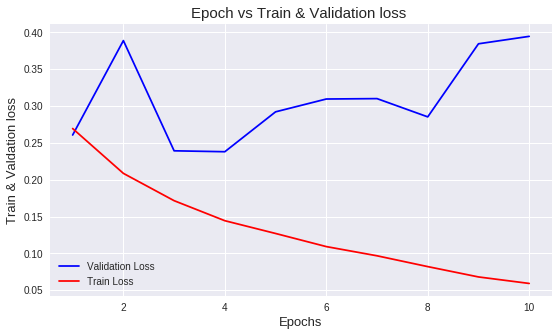

In [0]:
x=range(1,11)
validation_loss=model_trained.history['val_loss']
train_loss=model_trained.history['loss']

plotter(x,validation_loss,train_loss)

From test loss, 4 epochs seem to be an elbow point, post which the model starts overfitting.

In [0]:
#with open(r'/content/drive/My Drive/Colab Notebooks/lstm1_amazon_model1.pickle','wb') as f:
  pickle.dump(model,f)

In [0]:
with open(r'/content/drive/My Drive/Colab Notebooks/lstm1_amazon_model1.pickle','rb') as f:
  model=pickle.load(f)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [0]:
test_pred=model.predict_classes(X_test[:50000])
train_pred=model.predict_classes(X_train[:100000])


******************************************************************************* 

 Accuracy of train is 0.99288

 Accuracy of test is 0.89388

******************************************************************************* 

Classification report of train is 

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     11336
           1       0.99      1.00      1.00     88664

   micro avg       0.99      0.99      0.99    100000
   macro avg       0.99      0.97      0.98    100000
weighted avg       0.99      0.99      0.99    100000


******************************************************************************* 

Classification report of test is 

              precision    recall  f1-score   support

           0       0.73      0.56      0.63      8203
           1       0.92      0.96      0.94     41797

   micro avg       0.89      0.89      0.89     50000
   macro avg       0.82      0.76      0.79     50000
weighted avg       0.

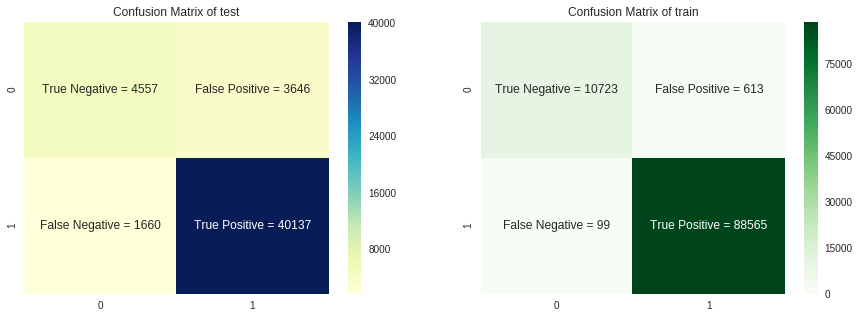

In [0]:
CM(y_test[:50000],test_pred,y_train[:100000],train_pred)

We reduce the number of epochs to 4 and see if we can obtain a better performing model.

In [0]:
start=dt.now()
model_trained=model.fit(X_train[:100000], y_train[:100000], nb_epoch=4, batch_size=128,validation_data=(X_test[50000:65000], y_test[50000:65000]))
print(f'Time taken to train is : {dt.now()-start}')
# Final evaluation of the model
scores = model.evaluate(X_test[:50000], y_test[:50000], verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Instructions for updating:
Use tf.cast instead.
Train on 100000 samples, validate on 15000 samples
Epoch 1/4
100000/100000 [==============================] - 1733s 17ms/step - loss: 0.2452 - acc: 0.9029 - val_loss: 0.2373 - val_acc: 0.9037
Epoch 2/4
100000/100000 [==============================] - 1688s 17ms/step - loss: 0.1706 - acc: 0.9313 - val_loss: 0.2371 - val_acc: 0.9051
Epoch 3/4
100000/100000 [==============================] - 1670s 17ms/step - loss: 0.1413 - acc: 0.9434 - val_loss: 0.2469 - val_acc: 0.8999
Epoch 4/4
100000/100000 [==============================] - 1648s 16ms/step - loss: 0.1163 - acc: 0.9547 - val_loss: 0.2741 - val_acc: 0.8989
Time taken to train is : 1:52:20.942705
Accuracy: 89.58%


In [0]:
#with open(r'/content/drive/My Drive/Colab Notebooks/lstm1_amazon_model1_tmp.pickle','wb') as f:
  pickle.dump(model,f)

In [0]:
with open(r'/content/drive/My Drive/Colab Notebooks/lstm1_amazon_model1_tmp.pickle','rb') as f:
  model=pickle.load(f)

In [0]:
test_pred=model.predict_classes(X_test[:50000])
train_pred=model.predict_classes(X_train[:100000])

#### Performance of Architecture 2:


******************************************************************************* 

 Accuracy of train is 0.96912

 Accuracy of test is 0.89582

******************************************************************************* 

Classification report of train is 

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     11336
           1       0.99      0.98      0.98     88664

   micro avg       0.97      0.97      0.97    100000
   macro avg       0.91      0.94      0.93    100000
weighted avg       0.97      0.97      0.97    100000


******************************************************************************* 

Classification report of test is 

              precision    recall  f1-score   support

           0       0.68      0.69      0.69      8203
           1       0.94      0.94      0.94     41797

   micro avg       0.90      0.90      0.90     50000
   macro avg       0.81      0.81      0.81     50000
weighted avg       0.

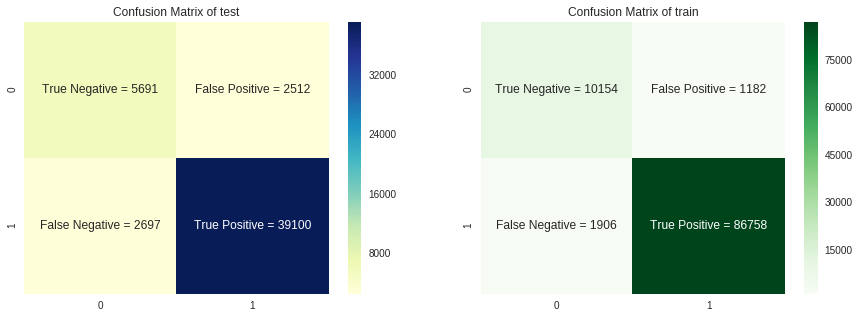

In [0]:
CM(y_test[:50000],test_pred,y_train[:100000],train_pred)

## <center> Performance comparision

In [3]:
tmp=pd.DataFrame(columns=['# Hidden Layers','Train accuracy','Test accuracy','Train F1','Test F1','No of epochs','Time to train'])

tmp.loc[0]=[2,0.9901,0.8903,0.98,0.80,'10','4:06']
tmp.loc[1]=[2,0.9932,0.8831,0.98,0.79,'3','1:29']
tmp.loc[2]=[4,0.9928,0.8938,0.98,0.79,'10','8:01']
tmp.loc[3]=[4,0.9691,0.8958,0.93,0.81,'4','1:52']

tmp


,# Hidden Layers,Train accuracy,Test accuracy,Train F1,Test F1,No of epochs,Time to train
0,2,0.9901,0.8903,0.98,0.80,10,4:06
1,2,0.9932,0.8831,0.98,0.79,3,1:29
2,4,0.9928,0.8938,0.98,0.79,10,8:01
3,4,0.9691,0.8958,0.93,0.81,4,1:52


## <center> Conclusion

Among the 2 different architectures, we can see that the model 2 is performing slightly better than 1 as obivously it is deeper.

* Architecture 2 with 4 epochs, is the best performing among the 2 designs.

* The data here is imbalanced and so we must use balanced class weight, also we didnt performed hyperparameter tuning for dropouts. If we take care of both the above mentioned ones, the model may work even very well.